In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


In [2]:
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(len(x_train))   # 학습 데이터는 60,000개가 있음

11493376/11490434 [==============================] - 0s 0us/step
60000


불러들인 숫자 손글씨 이미지 하나를 출력해보자. 

MNIST 데이터셋의 x_train은 이미지 데이터를 담는 행렬이고 y_train은 이 이미지에 대한 결과값, 즉 숫자이다.

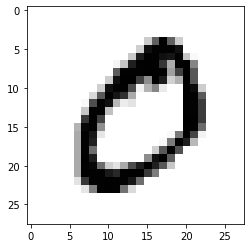

In [3]:
plt.imshow(x_train[1],cmap=plt.cm.binary)
plt.show()

숫자 0의 이미지가 나왔다. 이는 x_train[1]에 담긴 이미지의 의미는 0이라는 것이다.

마찬가지로 y항목의 내용도 출력해보자.

In [4]:
print(y_train[1])

0


y항목에는 x항목에 들어있는 이미지에 대응하는 실제 숫자값이 담겨있다.

학습 데이터는 60000개, 시험 데이터는 10000개가 저장되어있다

In [5]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


숫자 솔글씨 이미지의 실제 픽셀 값은 0부터 255 사이의 값을 가진다.

In [6]:
print('최소값 : ', np.min(x_train), '최대값 : ', np.max(x_train))

최소값 :  0 최대값 :  255


인공지능 모델을 훈련시키고 사용할 때, 

일반적으로 입력은 0 ~ 1 사이의 값으로 정규화 시켜주는 것이 좋다. MINIST 데이터는 각 픽셀 값이 0~255 사이 범위에 있으므로 데이터들을 255.0으로 나누어 준다.

최소값이 0, 최대값이 1에 근접하도록 나오는지 확인해보자.

In [7]:
x_train_norm, x_test_norm = x_train/255.0, x_test/255.0

print('최소값 : ', np.min(x_train_norm), '최대값 : ', np.max(x_test_norm))

최소값 :  0.0 최대값 :  1.0


# 네트워크 설계

`Conv2D(32, (5, 5), padding='valid', input_shape=(28, 28, 1), activation='relu')`

`Conv2D(필터수, 컨볼루션커널(필터)행렬, padding, 입력형태(가로x세로x필터)`

https://tykimos.github.io/2017/01/27/CNN_Layer_Talk/

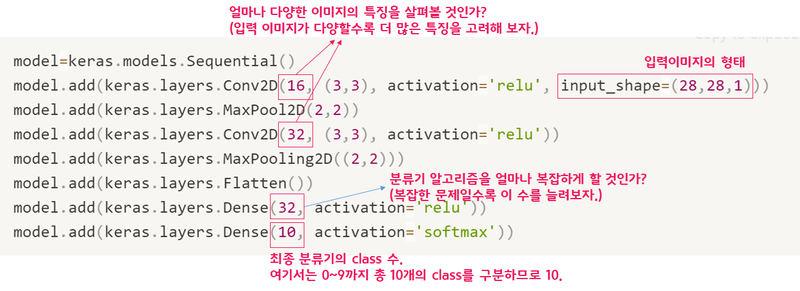

- Conv2D 레이어의 첫 번째 인자는 사용하는 이미지 특징의 수다. 여기서는 16과 32를 사용했다. 가장 먼저 16개의 이미지 특징을, 그 뒤에 32개의 이미지 특징씩을 고려하겠다는 의미다. 복잡한 이미지라면 (예. 사람 얼굴) 이 특징 숫자를 늘려주는 것을 고려할 수 있다.

- Dense 레이어의 첫번째 인자는 분류기에 사용되는 뉴런의 숫자다. 이 값이 클수록 보다 복잡한 분류기를 만들 수 있다. 
- 마지막 Dense 레이어의 뉴런 숫자는 결과적으로 분류해야하는 클래스 수로 지정하면 된다. 숫자 인식기에서는 10, 알파벳 인식기에서는 52가 된다

MaxPool2D / MaxPooling2D

```
tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), strides=None, padding='valid', data_format=None, **kwargs
)
```

https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D

In [8]:
model = keras.models.Sequential()

# 입력 필터 16개(각각 28 28 1), 3x3 컨볼루션 커널 
model.add(keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
model.add(keras.layers.MaxPool2D(2, 2)) # MaxPooling

model.add(keras.layers.Conv2D(32,(3, 3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation = 'relu'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

print("Model에 추가된 Layer 개수 : ", len(model.layers))

Model에 추가된 Layer 개수 :  7


In [9]:
# model.summary()

# 학습 진행시키기

우리가 만든 네트워크의 입력은 (데이터 개수, 이미지 크기x, 이미지 크기y, 채널수)와 같은 형태를 가진다. 이전 스텝에서 첫번째 레이어에 input_shape=(28, 28, 1)로 지정했었다.

그런데 print(x_train.shape)를 해보면, (60000, 28, 28)로 채널수에 대한 정보가 없다. 따라서 (60000, 28, 28, 1)로 만들어주어야 한다. (여기서 채널수 1은 흑백 이미지를 의미한다. 컬러 이미지라면 R, G, B 세가지 값이기 때문에 3이다.)

In [10]:
x_train_reshaped = x_train_norm.reshape(-1, 28, 28, 1) # 데이터 갯수에 -1을 쓰면 reshape시 자동으로 계산된다.
x_test_reshaped = x_test_norm.reshape(-1, 28, 28, 1)

이제 x_train 학습데이터로 딥러닝 네트워크를 학습시켜보자. 여기서 epochs = 10은 전체 60,000개의 데이터를 10번 반복해서 학습시키라는 의미다. 물론 model의 입력 정의에 형태를 맞춘 x_train_reshaped가 사용되어야 한다.

In [11]:
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

model.fit(x_train_reshaped, y_train, epochs = 10)

Epoch 1/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1952 - accuracy: 0.9404
Epoch 2/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0666 - accuracy: 0.9793
Epoch 3/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0486 - accuracy: 0.9849
Epoch 4/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0380 - accuracy: 0.9885
Epoch 5/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0303 - accuracy: 0.9904
Epoch 6/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0248 - accuracy: 0.9922
Epoch 7/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0210 - accuracy: 0.9931
Epoch 8/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0170 - accuracy: 0.9943
Epoch 9/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0149 - accuracy: 0.9952
Epoch 10/10
1875/1875 [==============================] - 31s 17m

# 데이터 평가하기

## 테스트 데이터로 성능을 확인해보기

위에 테스트는 validation set, 즉 training set의 일부를 사용한 것이다. 과연 이 모델이 test data에서도 잘 작용할까?

시험용 데이터 x_text를 가지고 확인해보자.

In [12]:
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test)

print("test_loss : {}".format(test_loss))
print("test_accuracy : {}".format(test_accuracy))

313/313 [==============================] - 2s 7ms/step - loss: 0.0334 - accuracy: 0.9897
test_loss : 0.03339843824505806
test_accuracy : 0.9897000193595886


결과가 나쁘지 않긴 하지만, 트레이닝셋보다 정확도가 떨어졌다.

model.evaluate() 대신 model.predict()를 사용하면 model이 입력값을 보고 실제로 추론한 확률분포를 출력할 수 있다. 

우리가 만든 model이란 사실 10개의 숫자 중 어느 것일지에 대한 확률값을 출력하는 함수다.

이 함수의 출력값, 즉 확률값이 가장 높은 숫자가 바로 model이 추론한 숫자가 된다.

> 참고: np.argmax의 axis

In [13]:
predicted_result = model.predict(x_test_reshaped) # 모델이 추론한 확률값.
predicted_labels = np.argmax(predicted_result, axis=1)

idx = 0 
print("model.predict() 결과 : ", predicted_result[idx])
print("model이 추론한 가장 가능성 높은 결과 : ", predicted_labels[idx])
print("실제 데이터의 라벨 : ", y_test[idx])

model.predict() 결과 :  [2.3114015e-12 7.3631493e-13 3.1728762e-11 8.5649893e-10 5.2782160e-14
 3.5687334e-12 8.9761469e-11 1.0000000e+00 1.4281369e-08 1.6206031e-10]
model이 추론한 가장 가능성 높은 결과 :  7
실제 데이터의 라벨 :  7


model.predict()의 결과가 [9.4768566e-08 3.2840468e-08 8.8844399e-06 1.0615840e-04 3.9865014e-09 1.3751206e-08 1.4640910e-11 9.9988484e-01 1.8163474e-08 3.6948819e-08]의 벡터 형태로 나왔다.

이 벡터는 model이 추론한 결과가 각각 0, 1, 2, ..., 7, 8, 9일 확률을 의미한다.

이 경우라면 model이 추론한 결과가 7일 확률이 1.00에 근접하고 있다. 즉, 이 모델은 입력한 이미지가 7이라는 것을 아주 확신하고 있다는 뜻이다.

한번 실제 결과를 확인해보자.

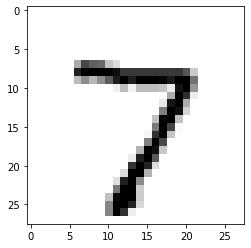

In [14]:
plt.imshow(x_test[idx], cmap = plt.cm.binary)
plt.show()

그렇다면 model이 추론해낸 숫자와 실제 라벨의 값이 다른 경우는 어떤 경우인지 직접 확인해보자.



예측 확률 분포 : [2.6069899e-04 3.2711154e-09 4.4097014e-08 4.8767564e-05 2.3231810e-09
 7.4580438e-02 1.9453381e-09 9.2468005e-01 5.0962046e-07 4.2962242e-04]
라벨 : 5, 예측 결과 : 7


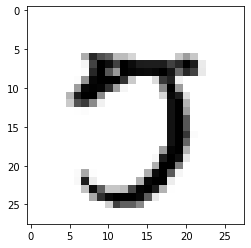

예측 확률 분포 : [6.4628301e-05 4.1503014e-07 2.6896737e-06 6.4172156e-07 5.6845582e-01
 6.2245853e-09 5.5681949e-07 4.5619873e-04 1.2239302e-02 4.1877973e-01]
라벨 : 9, 예측 결과 : 4


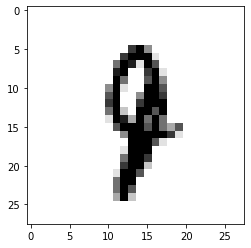

예측 확률 분포 : [1.2791282e-13 1.2421987e-07 7.2580308e-01 2.3616376e-09 1.0389585e-09
 2.2805713e-09 1.3968453e-09 5.2489281e-15 2.7419683e-01 2.8057310e-11]
라벨 : 8, 예측 결과 : 2


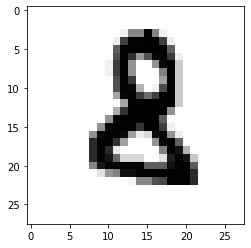

예측 확률 분포 : [1.02726859e-04 3.01855381e-11 1.94859406e-11 5.71083149e-07
 3.02169809e-08 8.68726730e-01 4.17421625e-10 1.11199975e-01
 1.35089280e-07 1.99698266e-02]
라벨 : 9, 예측 결과 : 5


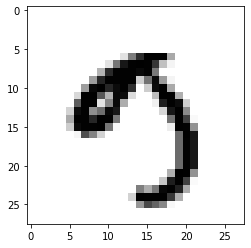

예측 확률 분포 : [9.5458008e-06 5.9950739e-06 9.8915422e-08 1.6113918e-06 2.2063311e-08
 9.0008879e-01 8.3661981e-02 7.8854495e-10 1.6014034e-02 2.1798887e-04]
라벨 : 6, 예측 결과 : 5


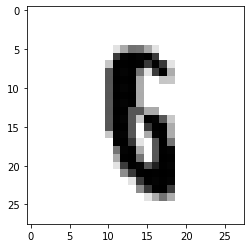

In [15]:
import random

wrong_predict_list = []

for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아보자.
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)
        
# wrong_predict_list에서 랜덤하게 5개만 뽑아보자.
samples = random.choices(population = wrong_predict_list, k=5)

for n in samples:
    print("예측 확률 분포 : " + str(predicted_result[n]))
    print("라벨 : " + str(y_test[n]) + ", 예측 결과 : " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap = plt.cm.binary)
    plt.show()

## (Option) 더 좋은 네트워크 만들어보기

더 높은 정확도를 이끌어내기 위해서 무엇을 할 수 있을까?

네트워크의 구조 자체는 바꾸지 않으면서도 해볼 수 있는 것들이 있다. 

대표적인 것이 파라미터들을 바꾸어보는 것인데, Conv2D 레이어에서 입력 이미지의 특징 수를 늘리거나 줄여보거나, Dense 레이어에서 뉴런 수를 바꾸어보거나, 학습 반복 횟수인 epoch 값을 변경해볼 수 있다.

In [16]:
# 바꿔볼 수 있는 파라미터들
n_channel_1 = 16
n_channel_2 = 32
n_dense = 48
n_train_epoch = 10

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3, 3), activation = 'relu', input_shape=(28, 28, 1)))
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.Conv2D(n_channel_2, (3, 3), activation = 'relu'))
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation = 'relu'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

model.summary()
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

# 모델 훈련
model.fit(x_train_reshaped, y_train, epochs = n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)
print("test_loss : {}".format(test_loss))
print("test_accuracy : {}".format(test_accuracy))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 48)                38448     
_________________________________________________________________
dense_3 (Dense)              (None, 10)               